# Implementing an opinion dynamics model

Last week we have implemented an SI epidemic spreading model. This time we will implement a different, but similarly simple model, which can be considered a simplified description of how opinions change in a society. The definition of the model is:

1. Each node is in one of two states, Red or Blue.
1. At each timestep, each node will count the number of their neighbors in each states, and if one of the two states has larger than two-thirds majority, it will switch to that state.

As we have seen last week, to implement a model, we will need to cover the following aspects:

1. Store the state of the simulation
1. Initialize the state at the beginning of the simulation
1. Update the state (i.e. run one timestep)
1. Save or display some output
1. Decide when to stop (how long to run)

In this case, to make our job easier, we have the following code as a starting point:

In [1]:
import networkx
import matplotlib.pyplot as plt

RED = 0
BLUE = 1

g = networkx.generators.grid_2d_graph(5,5)
nodes = [(i,j) for i in range(5) for j in range(5)]

pos = {n:n for n in nodes}

def checkerboard_pattern(x,y):
    d = {}
    next_color_red = True
    for i in range(x):
        for j in range(y):
            if next_color_red:
                d[(i,j)] = RED
                next_color_red = False
            else:
                d[(i,j)] = BLUE
                next_color_red = True
    return d

def draw(graph, positions, d):
    red_nodes = [n for n,c in d.items() if c == RED]
    blue_nodes = [n for n,c in d.items() if c == BLUE]
    networkx.draw_networkx_nodes(graph,positions,nodelist=red_nodes, node_color='r')
    networkx.draw_networkx_nodes(graph,positions,nodelist=blue_nodes,node_color='b')
    networkx.draw_networkx_edges(graph,positions)
    plt.show()


This code contains a function, checkerboard_pattern(), to initialize the state of the simulation, as well as a draw() function that will display the current state:

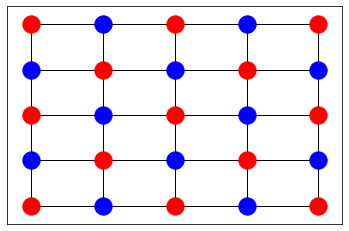

In [2]:
state = checkerboard_pattern(5,5)
draw(g, pos, state)

With the initialization, the "storing of the state" (in the "state" variable, which is a dictionary mapping nodes to RED or BLUE), as well as the results display taken care of, we can focus on the "update the state" part. Reading the definition of the dynamics a few times and writing out a straight-forward implementation, we get the following code:

In [3]:
def make_one_step(g, state):
    for node in nodes:
        # we are going to update each node: 
        # add up the number of neighbors in each state, and check whether there is a 2/3 majority.
        num_red_neighbors = 0
        for neighbor in g.neighbors(node):
            if state[neighbor] == RED:
                num_red_neighbors += 1
        
        fraction_of_red_neighbors = num_red_neighbors / len(list(g.neighbors(node)))
        if 2/3 < fraction_of_red_neighbors:
            state[node] = RED
        elif fraction_of_red_neighbors < 1/3: # I.e. if BLUE neighbors have a majority
            state[node] = BLUE 
    return state

Before we run the code above, we should take a moment, and consider what result we expect: after making one step, how do we expect our network to look like? If we have some guess, we can go ahead and run the code, plotting the state of the network before and after making one step:

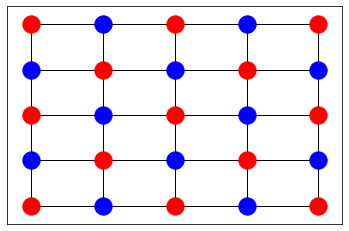

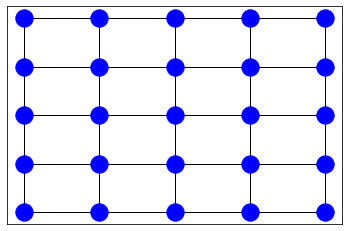

In [4]:
state = checkerboard_pattern(5,5)
draw(g, pos, state)
new_state = make_one_step(g, state)
draw(g, pos, new_state)

Well, that result looks a bit boring -- maybe we should go back and check whether we implemented the dynamics correct -- are all the rules followed? Is the network state updated correctly?

Doing some checks, we can convince ourselves that there is no issues with the code, and in fact, if we trace what the code is doing we can see that ending up with this end state is quite reasonable: if we iterate over the network node-by-node and row-by-row, starting with, say, the upper-left corner, then we can check what happens for each node: the node in the corner has two blue neighbors and thus turns blue, the node next to it has (now, since we updated the node in the corner) 2 red and 1 blue neighbors, and thus stays blue (since a larger than 2/3 majority is required), etc. Going over the network like this, we can easily check by hand that indeed, all the nodes will get turned blue.

At this point, we might feel that our model is a bit too artificial -- if we want to model opinion spreading, then using such a starting condition (where everyone has neighbors only of the other state) is quite unrealistic, or this network (a regular grid, while we know that actual social networks have small world and fat-tailed degree distribution properties and thus are very different from grids) is too simplistic. With such an artificial setup, no wonder we get a very artificial result. Making these aspects more realistic should lead to much more interesting results.

This is, of course, true. However, any detail where we would introduce more realism would also make the model more complicated. As mentioned last week, when trying to make a simple model as opposed to a detailed simulation, we should keep the model very simple. To stick to this simplicity, we can try fiddling with the way we update the state instead. The current version updates nodes one after the other, updating the state as we go along. This means that during this update, when we calculate the new state of a given node, some of its neighbors were already updated, and they have the new state, while others were not yet updated. To avoid this, we can try changing the code to ensure that we use a consistent state: for each node, for each neighbor we should use the previous state when doing the update. Essentially, we should ensure that instead of modifying the state as we go along, we should only record the new state in a different datastructure. This results in the following code:

In [5]:
def make_one_step2(g, state):
    new_state = state.copy() # the state after the update, initialized as a copy of the current state
    for node in nodes:
        num_red_neighbors = 0
        for neighbor in g.neighbors(node):
            if state[neighbor] == RED:
                num_red_neighbors += 1
        
        fraction_of_red_neighbors = num_red_neighbors / len(list(g.neighbors(node)))
        if 2/3 < fraction_of_red_neighbors:
            new_state[node] = RED
        elif fraction_of_red_neighbors < 1/3:
            new_state[node] = BLUE 
    return new_state

Note that although we are reading the state of the nodes from "state", this code does not modify that variable, instead it writes to "new_state", which is what is returned at the end of the function.

As before, we should pause for a second to consider what result we expect from this version. How is the distribution of opinions going to look like after one step, starting from our initial arrangment of the checkerboard pattern?

Once we have some guess, we can run the code, where we get the following:

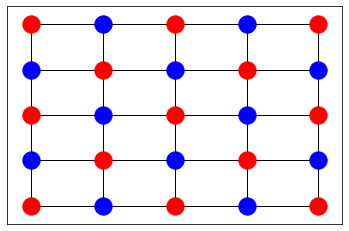

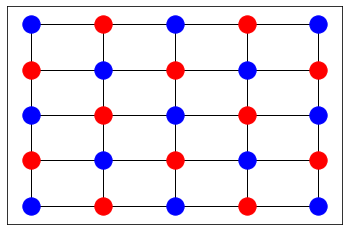

In [6]:
state = checkerboard_pattern(5,5) # start with the original state
draw(g, pos, state)
new_state = make_one_step2(g, state)
draw(g, pos, new_state)

It appears that what we got is still pretty artificial. Tracing what happens we can quickly identify what is going on. Each node is updated idependently of updating others, only considering the old state of the neighbors, and each node is surrounded by nodes of the opposite color, so everyone will switch to the opposite state.

For these two variants, we ran only one step, but it is easy to see what will happen with successive steps: in the first case, where all nodes end up the same color after the first timestep, we end up in a "frozen" state, where no nodes will change their state in later timesteps. In the second case, when using make_one_step2(), running one more timestep will make all nodes flip again, and we will keep switching between these two states in future timesteps.

With both of our attempts so far resulting in uninteresting, artificial results, we might be tempted to call it a day give up. But before we do that, lets try one more thing: when trying to "fix" our first attempt, we said that the artificial result is due to updating based on an inconsistent state (using the new state of some neighbors and the old state of others). There is, however, another aspect to the update that contributes to the outcome: the fact that we iterate over the nodes in a given order. Possibly varying the order in which we update the nodes might give better results? The definitions that we follow don't mention anything about what order to use (only that each node should be updated in each timestep), so we should be free to use whatever order we wish.

Of the two variants we have so far, changing the order of the nodes won't cause any difference for make_one_step2(): that variant will produce the same result since it uses the old state of every node when determining the new state of the nodes. For our first implementation, however, make_one_step(), we can expect some dependence on the ordering. For example, we can come up with an ordering of the nodes which will turn all nodes to red instead of turning nem blue. What ordering should we use?

To avoid biasing the outcome with the order, a good choice is to use some random ordering: that should ensure that we are not picking a result we like, and also means that we can generate a range of outcomes by running the script multiple times and seeing how disparate results we get.

The code that implements this random order update might look like the following -- it is essentially the same as make_one_step() before, except that we shuffle the nodes before iterating over them:

In [7]:
import random

def make_one_step__random_order(g, state):
    nodes_in_random_order = nodes[:] # make a copy of nodes
    random.shuffle(nodes_in_random_order) # shuffle, in-place
    for node in nodes_in_random_order:
        num_red_neighbors = 0
        for neighbor in g.neighbors(node):
            if state[neighbor] == RED:
                num_red_neighbors += 1
        
        fraction_of_red_neighbors = num_red_neighbors / len(list(g.neighbors(node)))
        if 2/3 < fraction_of_red_neighbors:
            state[node] = RED
        elif fraction_of_red_neighbors < 1/3: # I.e. if BLUE neighbors have a majority
            state[node] = BLUE 
    return state

As before, we should, before running the code, take a minute to consider what we expect to happen. Obviously the exact result should be somewhat random, but can we describe the general characteristics of how the resulting state should look like?

Running the code, we get the following:

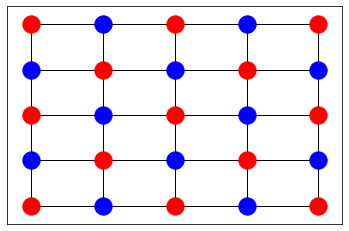

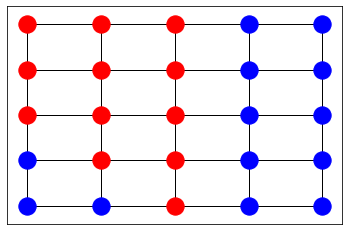

In [8]:
state = checkerboard_pattern(5,5)
draw(g, pos, state)
new_state = make_one_step__random_order(g, state)
draw(g, pos, new_state)

This result certainly looks much more interesting than the previous two tries! We can identify "blocks" of nodes of the same color, as well as the border between these blocks. Running the code a few times, often we get results which are "frozen" after one step, but in some cases, there are changes on the second or even third timestep as well. However, in all cases we reach a "frozen" state in a few steps. In this final state, usually we have nodes of both colors, but arranged in blocks where none of the nodes is going to change. (Checking that a state is fairly simple, we only have to look for nodes which would change their state according to the update rule if they would be the next one to be updated. If one node changes it state, that might cause others to change as well, but if no node has a larger than two-third majority of the other state around it, then the state is "frozen".)

Considering that all three variants above satisfy the description of our opinion dynamics model, they can all be considered equally "correct" implementation of the model. Comparing their behaviour, however, we can rightfully conclude that the third variant is the best one, the most useful one, since it gives the most realistic results even with such heavily artificial initial conditions.

# Comparing our epidemic spreading and opinion dynamics implementation

With these lessons learned, we might want to think back to our epidemic spreading model: last week we implemented an SI model which produced some realistic results. There we essentially stopped with the first variant: although we did tweak various aspects of the code, those aspects related to how many timesteps we simulated, etc., and did not affect the inner loop of making one timestep. Considering that for the opinion dynamics model, it took us 3 tries to get some realistic behaviour, did we get lucky with the SI model? Or maybe some other SI implementation would improve on our code?

Can we compare the opinion dynamics implementations to our SI implementation from last week? This rightfully sounds quite strange -- after all, due to the differences in the models they implement, no such comparison should be possible: an SI model is different from an opinion dynamics model: the definition of the states, the rules for updating them, etc. are all different. Still, we can ask the question: of these three opinion dynamics implementation, which is most similar to last week's SI implementation? To answer this question, we need to ignore the known differences, and focus on the most general aspects of a dynamical model: the status update, and how that is organized.

For the opinion dynamics, we have 3 implementations. The second one (make_one_step2) can be considered a synchronous update, in that all nodes "update at the same time". Note that this phrasing is actually quite meaningless: at the implementation level, this cannot be true, since our python script is single-threaded, i.e. only one thing can happen at a time. In this sense, this update cannot happen at the same CPU-time. Of course, this CPU time is just an implementation detail, what we should consider important is model-time, i.e. the time according to the model's definition. However, one could argue that in this sense this statement is tautological, since all implementations that follow the model's definition have to update each node at the same time: after all, the definition of the model states, that each node is updated at each time-step. The statement that make_one_step2 "updates nodes at the same time" should make more sense when we consider that our first variant, make_one_step, can be considered to be asynchronous, to "update nodes one after the other". Again, this strictly speaking is not true in model-time (since the time the model defines is discrete, and nothing happens between two time-steps), and is tautological in CPU-time. However, the fact that make_one_step uses a "mixed state" of the previous and next state when calculating the update means that the best description of the difference might introduct a concept of "sub-time-step" with a higher resolution than the time-steps defined by the model.

So, to summarize, for the opinion dynamics, we have an asynchronous update variant (make_one_step), a synchronous variant (make_one_step2), as well as a randomized version of the asynchronous update variant (make_one_step__random_order). For completeness, we could also consider a randomized version of the synchronous variant, but as we have mentioned above, that would behave exactly the same as our synchronous variant (make_one_step2), since  the randomization would make no difference.

With this categorization of synchronous / asynchronous update, it should be easier to make the comparison to the SI implementation we wrote last week. That code is:

In [9]:
S = 'S'; I = 'I'
def si_infection_model__run_some_steps(result, g, Lambda, node_states, num_timesteps):
    for timestep in range(num_timesteps):
        for node in g.nodes(): # for each time-step, iterate over all nodes and try to infect neighbors:
            if node_states[node] is I:
                for neighbor in g.neighbors(node):
                    if random.random() < Lambda:
                        node_states[neighbor] = I
        num_infected_nodes = len([node for node in g.nodes() if node_states[node] == I])
        result.append(num_infected_nodes)
    
    return result, g, Lambda, node_states

Focusing on the update rule, we can see that we iterate over the nodes, and check the current state from node_states, and also store the new state in node_states -- i.e. we are writing the same datastructure that we are reading from. With the terminology we used above, this makes this an asynchronous update rule, similar to the make_one_step variant of the opinion dynamics.

As we have seen with the opinion dynamics, different variants have different behaviour, even if they follow the same rules, and some of these might be "wrong" -- can we decide whether our SI model implementation is good or bad? Are there situations where it would behave incorrectly? For the opinion dynamics implementation, our issue with the original asynchronous was that the order in which we iterate over the nodes determined the result in some situations. Can we construct such a sitation for the SI dynamics?

For example, lets consider a chain of nodes, where the infection starts at one end of the chain (i.e. the very first node in the chain is Infected, the rest are Susceptible). Lets see what happens if we set the infection probability to 1, i.e. at each timestep, the infect will spread deterministically to the next node:

In [10]:
g = networkx.path_graph(10)
node_states = {node:S for node in g.nodes()}
node_states[0] = I
result = [1]

Lambda = 1
result, g, Lambda, node_states = si_infection_model__run_some_steps(result, g, Lambda, node_states, 1)
print(result)

[1, 10]


As we can see, the infection jumped from 1 infected node (the starting condition) to infecting every node in one timestep. Even worse, if we start the infection from the other end of the chain:

In [11]:
node_states = {node:S for node in g.nodes()}
node_states[9] = I
result = [1]

Lambda = 1
result, g, Lambda, node_states = si_infection_model__run_some_steps(result, g, Lambda, node_states, 9)
print(result)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In this case, the infection infects one node in each timestep, which means that we need 9 more steps to infect the remaining 9 nodes in the network. This means that the speed of our infection is very different in the two directions. We managed to implement an infection-spreading model where the infection spreads relatively slowly (as it should, taking one timestep to spread along one edge) in one direction, but instantaneously in the other direction!

The reason for this should be quite clear with a bit of analysis: if we iterate over the nodes in the order of their id, and use the new state of the nodes we already updated, we end up marking each node infected. We thus end up marking nodes infected even if their neighbor got infected in the same timestep, i.e. it had no infected neighbor in the previous timestep.

Obviously, this cannot be right. To fix it, we can try the same approach that we did with the opinion dynamics. First, lets try switching to a synchronous update impementation. To do this, we need to store the new state seperately, and to ensure that we don't modify the same datastructure that we read from. Making this change, we get something like the following:

In [12]:
def si_infection_model__synchronous(result, g, Lambda, node_states, num_timesteps):
    for timestep in range(num_timesteps):
        new_node_states = node_states.copy()
        for node in g.nodes(): # for each time-step, iterate over all nodes and try to infect neighbors:
            if node_states[node] is I:
                for neighbor in g.neighbors(node):
                    if random.random() < Lambda:
                        new_node_states[neighbor] = I
        
        node_states = new_node_states
        num_infected_nodes = len([node for node in g.nodes() if node_states[node] == I])
        result.append(num_infected_nodes)
    
    return result, g, Lambda, new_node_states

Running the "chain of nodes" test for this implementation:

In [13]:
g = networkx.path_graph(10)
node_states = {node:S for node in g.nodes()}
node_states[0] = I
result = [1]

Lambda = 1
result, g, Lambda, node_states = si_infection_model__synchronous(result, g, Lambda, node_states, 9)
print(result)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


And, just to verify, in the other direction:

In [14]:
node_states = {node:S for node in g.nodes()}
node_states[9] = I
result = [1]

Lambda = 1
result, g, Lambda, node_states = si_infection_model__synchronous(result, g, Lambda, node_states, 9)
print(result)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


# Another aspect for synchronous vs. asynchronous update

We have mentioned last week, that there are several ways to store the state of the simulation. We only implemented one of these, using a dictionary to store the S and I state of the nodes. Another option mentioned last week was to use an infected_nodes set, storing the nodes that are infected. A variant using that way to store the state might look like this:

In [15]:
g = networkx.gnp_random_graph(1000, 0.1) # some network to run on
Lambda = 0.01 # the infection probability
infected_nodes = set([random.choice(list(g.nodes()))])# start with one, randomly chosen node in I state

for i in range(5):
    for node in g.nodes():
        if node in infected_nodes: # equivalent to "if node_states[node] is I"
            for neighbor in g.neighbors(node):
                if random.random() < Lambda:
                    infected_nodes.add(neighbor)

The code above iterates over all nodes and checks whether the current node is in infected_nodes since the body of the loop should only be run for infected nodes. This seems somewhat wasteful: after all, we could iterate over infected_nodes itself, which should speed up the code:

In [16]:
for i in range(5):
    # replacing "for node in g.nodes()" and "if node in infected_nodes" 
    # with a single iteration over infected_nodes:
    for node in infected_nodes:
        for neighbor in g.neighbors(node):
            if random.random() < Lambda:
                infected_nodes.add(neighbor)
    print(len(infected_nodes))

RuntimeError: Set changed size during iteration

Unfortunately, this doesn't appear to work: depending on the datastructure and programming environment used, we might not be able to modify a datastructure when we are iterating over it. An easy solution to this issue is to make a copy, and either modify the copy as we iterate over the original, or iterate over the copy as we modify  the original. In either case, this would mean that technical aspects push us towards using an asynchronous update. This might not be an issue if both a synchronous and an asynchronous update work for the model we are implementing, but we should be aware of this choice even if we make it accidentially.

In this case, making and modifying a copy, our code might look like the following:

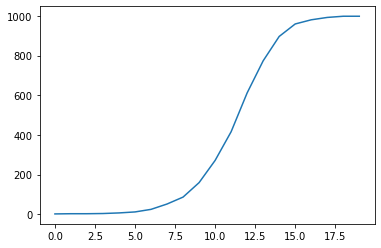

In [17]:
def si_model_one_step_using_set(result, g, Lambda, infected_nodes):
    # replacing "for node in g.nodes()" and "if node in infected_nodes" 
    # with a single iteration over infected_nodes:
    new_infected_nodes = infected_nodes.copy()
    for node in infected_nodes:
        for neighbor in g.neighbors(node):
            if random.random() < Lambda:
                new_infected_nodes.add(neighbor)
    infected_nodes = new_infected_nodes
    result.append(len(infected_nodes))
    return result, g, Lambda, infected_nodes

g = networkx.gnp_random_graph(1000, 0.1)
Lambda = 0.01
infected_nodes = set([random.choice(list(g.nodes()))])
result = []
for i in range(20):
    result, g, Lambda, infected_nodes = si_model_one_step_using_set(result, g, Lambda, infected_nodes)
plt.plot(result)

# Increasing temporal resolution: making smaller steps

Our SI infection curves look reasonably good, showing the spread of the epidemic. For the opinion dynamics, however, we might disappointed in the temporal resolution: we essentially reach the final state in a single step. (Even if some node's state changes in the second and third step, that is a very small change and at most a few steps are needed to reach a fully "frozen" final state.)

To show more detail, we might want to tweak the model a bit, to advance time in smaller steps. For the opinion dynamics model, for the first two implementations, this would be quite problematic, since it would mean, for example, only updating the top or the bottom nodes, introducing an obvious bias. For the third implementation, however, we can easily update only a fraction of the nodes and still avoid such bias, since the nodes will be chosen randomly. This "small step update" (taken to the logical extreme, i.e. updating only a single node for each timestep) implementation might look like this:

In [18]:
def make_one_small_step(g, state):
    node = random.choice(nodes) # choose a single node at random, and only update that node:

    num_red_neighbors = 0
    for neighbor in g.neighbors(node):
        if state[neighbor] == RED:
            num_red_neighbors += 1

    fraction_of_red_neighbors = num_red_neighbors / len(list(g.neighbors(node)))
    if 2/3 < fraction_of_red_neighbors:
        state[node] = RED
    elif fraction_of_red_neighbors < 1/3: # I.e. if BLUE neighbors have a majority
        state[node] = BLUE 

    return state

The scaling factor between the two timesteps is the number of nodes: the original version, make_one_step__random_order, updated each node in one timestep, this new version updates only one, so the conversion factor between the small and the original timestep is N, the number of nodes.

Note that N small timesteps won't be completely equivalent to one original timestep: with the current implementations, when making small steps, we have no guarantee that we will update each node exactly once in N steps, while that was true for the one original timestep. Considering the randomness of the update, this shouldn't cause a difference in the overall behaviour, but it might be a factor to consider.

For the SI dynamics, we can also implement such a "small timestep" variant. Using the "infected_nodes" state, and doing the same, i.e. updating one randomly chosen node, we might get the following:

In [19]:
def si_model_one_small_step(result, g, Lambda, infected_nodes):
    node = random.choice(list(infected_nodes))
    for neighbor in g.neighbors(node):
        if random.random() < Lambda:
            infected_nodes.add(neighbor)
    result.append(len(infected_nodes))
    return result, g, Lambda, infected_nodes

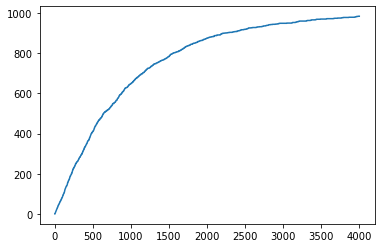

In [20]:
g = networkx.gnp_random_graph(1000, 0.1) # some network to run on
Lambda = 0.01 # the infection probability
infected_nodes = set([random.choice(list(g.nodes()))])# start with one, randomly chosen node in I state
result = [1]

for i in range(4000):
    result, g, Lambda, infected_nodes = si_model_one_small_step(result, g, Lambda, infected_nodes)

plt.plot(result)

which apparently give a pretty strange result: instead of the S-shaped curve, we get a very different curve. Working out why and how to fix it is left as an optional exercise. (The solution will be discussed next week.)